In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import os, glob
from natsort import natsorted
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

from tensorflow import keras
from tensorflow.keras import layers

# Load data into generator

In [6]:
data_dir = '../data/train'
data_dir = pathlib.Path(data_dir)

data_val_dir = '../data/val'
data_val_dir = pathlib.Path(data_val_dir)

data_test_dir = '../data/test'
data_test_dir = pathlib.Path(data_test_dir)

### Load labels

In [7]:
df_labels = pd.read_csv('../data/labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])
df_val_labels = pd.read_csv('../data/val_labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])
df_test_labels = pd.read_csv('../data/test_labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])

In [8]:
def generate_class_list(df):
    class_labels_list = df[['class']].values.tolist()

    y_list = []
    for x in class_labels_list:
        y_list.append(x[0])
        
    return y_list

In [9]:
def generate_bbox_list(df):
    return df[['x', 'y', 'w', 'h']].values.tolist()

In [10]:
def generate_labels_bbox_list(df):
    return df[['class', 'x', 'y', 'w', 'h']].values.tolist()

In [11]:
class_list = generate_class_list(df_labels)
class_val_list = generate_class_list(df_val_labels)
class_test_list = generate_class_list(df_test_labels)

bbox_list = generate_bbox_list(df_labels)
bbox_val_list = generate_bbox_list(df_val_labels)
bbox_test_list = generate_bbox_list(df_test_labels)
    
print('First 10 labels: ', class_list[0:10])
print('First 10 bboxes: ', bbox_list[0:10])
print('Number of labels: ', len(class_list))

First 10 labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 bboxes:  [[0, 0, 62, 62], [46, 5, 8, 8], [31, 7, 16, 16], [29, 9, 10, 10], [2, 2, 52, 52], [18, 23, 38, 38], [4, 3, 58, 58], [26, 18, 24, 24], [9, 11, 28, 28], [17, 19, 42, 42]]
Number of labels:  2000


In [12]:
y_list = generate_labels_bbox_list(df_labels)
y_val_list = generate_labels_bbox_list(df_val_labels)

print('First 5 labels: ', y_list[0:5])
print('Number of labels: ', len(class_list))

First 5 labels:  [[0, 0, 0, 62, 62], [0, 46, 5, 8, 8], [0, 31, 7, 16, 16], [0, 29, 9, 10, 10], [0, 2, 2, 52, 52]]
Number of labels:  2000


## Test new generator

In [13]:
def combine_labels_bbox(labels_list, bbox_list):
    #y_list =[]
    #for label, bbox in zip(labels_list, bbox_list):
    #    y_list.append([[label], bbox])
    
    y_list = [labels_list, bbox_list]
    return y_list

In [14]:
test_list = combine_labels_bbox(class_list, bbox_list)
len(test_list[1])

2000

In [301]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels1, labels2, batch_size=32, dim=(64,64,3), shuffle=True, grayscale = True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels1 = labels1
        self.labels2 = labels2
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.grayscale = grayscale
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y1 = np.empty((self.batch_size), dtype=int)
        y2 = np.empty((self.batch_size, 4), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = plt.imread(ID)
            
            img_class = ID[-17]
            img_number = int(ID[-8:-4])
            
            if img_class == '0':
                y1[i] = self.labels1[img_number]
                y2[i,] = self.labels2[img_number]
            else:
                y1[i] = self.labels1[1000+img_number]
                y2[i,] = self.labels2[1000+img_number]
    
        if self.grayscale:
            X = X[:,:,:,0]

        return X, [y1, y2]

In [302]:
data = glob.glob('../data/train/*/*')

In [303]:
data[1003][-8:-4]

'0003'

In [304]:
train_dg = DataGenerator(data, class_list, bbox_list ,shuffle = True)

In [317]:
test = train_dg.__getitem__(1)
test[1][1][0]

array([ 7, 21, 29, 31])

### Load test data

### Visualize the data 

In [306]:
sample_batch = train_dg.__getitem__(1)
sample_batch[0][0].shape

(64, 64)

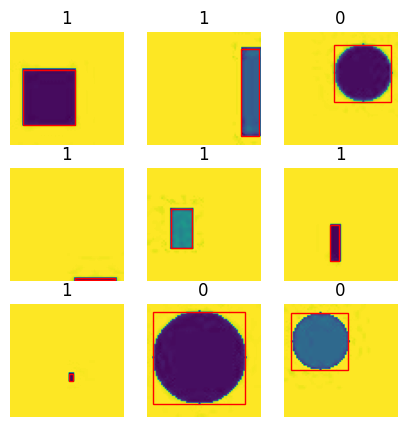

In [320]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sample_batch = train_dg.__getitem__(1)
plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_batch[0][i].astype("uint8"))
    rect = patches.Rectangle((sample_batch[1][1][i][0], sample_batch[1][1][i][1]), sample_batch[1][1][i][2], sample_batch[1][1][i][3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.set_title(sample_batch[1][0][i])
    plt.axis("off")

## Old generator (doesn't work with multiple output with different sizes)

### Load images into generator

In [121]:
batch_size = 32
img_height = 64
img_width = 64

labels = test_list
val_labels = y_val_list

label_mode = 'int'
shuffle = False

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = labels,
    label_mode = label_mode,
    color_mode = 'grayscale',
    shuffle = shuffle,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_val_dir,
    labels = val_labels,
    label_mode = label_mode,
    color_mode = 'grayscale',
    shuffle = shuffle,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.


ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [100]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.int32, name=None))>

In [130]:
ds = tf.data.Dataset.from_generator(X.__getitem__)

TypeError: To specify the output signature you need to provide either the `output_signature` argument or the `output_types` argument.

In [42]:
for image_batch, labels_batch in train_ds:
    print('Image batch shape: ', image_batch.shape)
    print('Labels batch shape: ', labels_batch.shape)
    break

Image batch shape:  (32, 64, 64, 1)
Labels batch shape:  (32, 5)


### Buffer prefetching

In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [77]:
Y_class = []
Y_bbox = []
Y_val_class = []
Y_val_bbox = []

for _, labels_batch in train_ds:
    for label in labels_batch:
        Y_class.append(label[0].numpy())
        Y_bbox.append(label[1:].numpy())
        
for _, labels_batch in val_ds:
    for label in labels_batch:
        Y_val_class.append(label[0].numpy())
        Y_val_bbox.append(label[1:].numpy())

In [79]:
print(np.array(Y_class).shape)
print(np.array(Y_bbox).shape)

print(np.array(Y_val_class).shape)
print(np.array(Y_val_bbox).shape)

(2000,)
(2000, 4)
(200,)
(200, 4)


# Model definition and training

#### helpers

In [383]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
def printScores(y_pred, y_true):
    print("Classification report:")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    
def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')
    
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x3, y3, w2, h2 = box2[0], box2[1], box2[2], box2[3]
    
    x2, y2 = x1 + w1, y1 + h1
    x4, y4 = x1 + w1, y1 + h1
    
    x_inter1 = max(x1, x3)
    y_inter1 = max(y1, y3)
    x_inter2 = min(x2, x4)
    y_inter2 = min(y2, y4)
    width_inter = abs(x_inter2 - x_inter1)
    height_inter = abs(y_inter2 - y_inter1)
    area_inter = width_inter * height_inter
    width_box1 = abs(x2 - x1)
    height_box1 = abs(y2 - y1)
    width_box2 = abs(x4 - x3)
    height_box2 = abs(y4 - y3)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter
    iou = area_inter / area_union
    if iou > 1:
        iou = 0
    return iou

### class-defined model

In [323]:
def CNN_class(nFilters, kernel_size, pool_size, nNeurons, inputShape, class_outputWidth, bbox_outputWidth):
    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    x = tf.keras.layers.Rescaling(1./255, input_shape=inputShape)(x)
    x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
    x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(int(nNeurons / 2), activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(int(nNeurons / 2), activation=tf.nn.relu)(x)
    
    output_class = tf.keras.layers.Dense(class_outputWidth, activation=tf.nn.softmax, name = 'class_output')(x)
    output_bbox = tf.keras.layers.Dense(bbox_outputWidth, name = 'bbox_output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=[output_class, output_bbox])
    model.compile(optimizer='adam', loss={'class_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'bbox_output': tf.keras.losses.mse},  metrics={'class_output': ['accuracy'], 'bbox_output': None})
    
    #model = tf.keras.Model(inputs=inputs, outputs=output_class)
    #model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

### model training

In [326]:
%%time 

batch_size = 32
nFilters = 32
kernel_size = 3
pool_size = (3,3)
nNeurons = 128 
nHiddenLayers = 1 
inputShape = (64, 64, 1)
class_outputWidth = 2
bbox_outputWidth = 4

epochs = 30

model = CNN_class(nFilters, kernel_size, pool_size, nNeurons, inputShape, class_outputWidth, bbox_outputWidth)

model.fit(train_dg, epochs = epochs)

Epoch 1/30
62/62 [==============================] - 2s 18ms/step - loss: 444.4471 - class_output_loss: 1.2096 - bbox_output_loss: 443.2376 - class_output_accuracy: 0.4728
Epoch 2/30
62/62 [==============================] - 1s 17ms/step - loss: 274.7957 - class_output_loss: 2.5734 - bbox_output_loss: 272.2223 - class_output_accuracy: 0.3810
Epoch 3/30
62/62 [==============================] - 1s 17ms/step - loss: 213.6638 - class_output_loss: 0.9601 - bbox_output_loss: 212.7038 - class_output_accuracy: 0.5756
Epoch 4/30
62/62 [==============================] - 1s 17ms/step - loss: 203.9461 - class_output_loss: 0.6823 - bbox_output_loss: 203.2637 - class_output_accuracy: 0.6497
Epoch 5/30
62/62 [==============================] - 1s 18ms/step - loss: 187.5284 - class_output_loss: 0.7012 - bbox_output_loss: 186.8272 - class_output_accuracy: 0.6285
Epoch 6/30
62/62 [==============================] - 1s 19ms/step - loss: 190.5240 - class_output_loss: 0.7014 - bbox_output_loss: 189.8227 - clas

### testing on test dataset

In [328]:
import glob

test = glob.glob('../data/test/*/*')
test_labels = 

In [373]:
def test_predict(data_dir):
    class_predictions = []
    bbox_predictions = []
    for path in data_dir:
        img = tf.keras.utils.load_img(path, color_mode='grayscale')
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        y = model.predict(img_array, verbose = 0)
        class_predictions.append(np.argmax(y[0][0]))
        bbox_predictions.append(y[1][0])
                  
    return class_predictions, bbox_predictions

In [374]:
pred_class, pred_bbox  = test_predict(test)

In [375]:
printScores(pred_class, class_test_list)

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       300
           1       0.72      0.73      0.73       300

    accuracy                           0.72       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.72      0.72      0.72       600

Confusion matrix:
[[214  86]
 [ 80 220]]


In [389]:
pred_bbox[0]

array([17.753033,  7.426487, 15.556524, 13.641514], dtype=float32)

In [390]:
iou = []
for i in range(len(bbox_test_list)):
    iou.append(calculate_iou(bbox_test_list[i], pred_bbox[i]))

In [391]:
print('Mean IoU: ', np.round(np.mean(iou), 2))
print('Mean IoU without 0s: ', np.round(np.mean([i for i in iou if i != 0]), 2))

Mean IoU:  0.62
Mean IoU without 0s:  0.64


4 11 50 50
3.1967247 12.407364 48.367348 48.772247


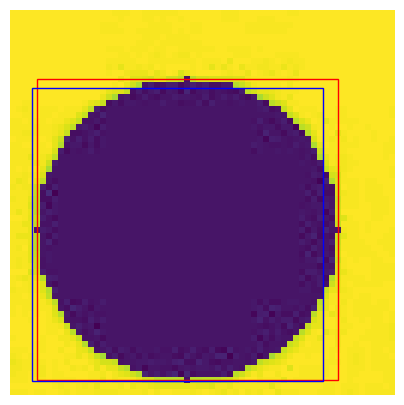

In [394]:
n = 120

x1, y1, wt, ht = bbox_test_list[n]
x2, y2, wp, hp = pred_bbox[n]
print(x1, y1, wt, ht)
print(x2, y2, wp, hp)

fig = plt.figure(figsize = (5,5))
img = tf.keras.utils.load_img(test[n], color_mode='grayscale')
img_array = tf.keras.utils.img_to_array(img)
plt.imshow(img_array.astype("uint8"))
rect_true = patches.Rectangle((x1, y1), wt, ht, linewidth=1, edgecolor='r', facecolor='none')
rect_pred = patches.Rectangle((x2, y2), wp, hp, linewidth=1, edgecolor='b', facecolor='none')
plt.gca().add_patch(rect_true)
plt.gca().add_patch(rect_pred)
plt.axis("off")
plt.show()